In [117]:
import cv2
import numpy as np
from scipy.spatial.transform import Rotation
from math import sin, cos, radians, degrees, pi
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
%matplotlib notebook


In [58]:
def skew(vector):
    return np.array([[0, -vector[2], vector[1]], 
                     [vector[2], 0, -vector[0]], 
                     [-vector[1], vector[0], 0]])

def evalRt(R_est, t_est, euler, t):
    euler_est = Rotation.from_matrix(R_est).as_euler('xyz')
    t_est = t_est.reshape(3)
    for i in range(3):
        if euler_est[i] > pi / 2:
            euler_est[i] -= pi
    euler_err = np.linalg.norm(np.minimum(np.abs(euler_est - euler), np.abs(euler - euler_est))) / np.linalg.norm(euler)
    t_est = t_est / np.linalg.norm(t_est) * np.linalg.norm(t) # rescale
    t_err = np.linalg.norm(np.abs(t - t_est)) / np.linalg.norm(t)
    print("t ground truth: ", t)
    print("t est: ",t_est)
    print("euelr gt: ", euler)
    print("euler est: ", euler_est)
    print("t err: ", t_err)
    print("euler err: ", euler_err)
    print("\n")

### Generate 3d points and 2d pixels

In [115]:
# initialize transformation
baseline = 0.3162277  # distance from joint to camera optical center, 1cm
theta = radians(10)
euler = np.array([0, theta, 0])  # joint rotation angle in degrees
R = Rotation.from_euler('xyz', euler, degrees=False)
t = np.array([baseline * sin(theta), 0, -(baseline - baseline * cos(theta))])
T = np.zeros((4, 4))
T[:3, :3] = R.as_matrix()
T[3,3] = 1.
T[:3, 3] = t
print(t)

# set initial points (10), x [-0.2, 0.2], y in [-0.15, .15], z in [0.1, .3]
N_PTS = 50
pt_w = np.random.random((N_PTS, 3))
pt_w[:, 0] = pt_w[:, 0] * 0.4 - 0.2
pt_w[:, 1] = pt_w[:, 1] * 0.3 - 0.15
pt_w[:, 2] = pt_w[:, 2] * 0.2 + 0.1

pt_w_h = np.ones((N_PTS, 4)) # homogeneous coordinates
pt_w_h[:, :3] = pt_w

# get pixels in 2d with noise and integer round up error
K = np.array([[339.4, 0, 321.9], [0, 339.7, 226.2], [0, 0, 1.]])
puv1 = (np.matmul(K, pt_w_h.T[:3, :]) / np.tile(np.matmul(K, pt_w_h.T[:3, :])[2,:], (3,1)))[:2, :].T
puv2 = (np.matmul(K, np.matmul(T, pt_w_h.T)[:3, :]) / np.tile(np.matmul(K, np.matmul(T, pt_w_h.T)[:3, :])[2, :], (3,1)))[:2,:].T
puv1_ni = np.int32(np.rint(puv1 + np.random.normal(scale=3, size=(N_PTS, 2))))
puv2_ni = np.int32(np.rint(puv2 + np.random.normal(scale=3, size=(N_PTS, 2))))

[ 0.05491236  0.         -0.00480421]


### Estimate fundamental, solve for R t, and eval error rate

In [116]:
F, mask = cv2.findFundamentalMat(puv1_ni, puv2_ni, cv2.FM_8POINT)
E = K.T.dot(F).dot(K)
R1, R2, t_est = cv2.decomposeEssentialMat(E)
evalRt(R1, t_est, euler, t)
evalRt(R2, -t_est, euler, t)

t ground truth:  [ 0.05491236  0.         -0.00480421]
t est:  [ 0.05486748  0.00073437 -0.00524105]
euelr gt:  [0.         0.17453293 0.        ]
euler est:  [0.00386695 0.17796284 0.00453457]
t err:  0.01552292181372544
euler err:  0.03939681198211058


t ground truth:  [ 0.05491236  0.         -0.00480421]
t est:  [-0.05486748 -0.00073437  0.00524105]
euelr gt:  [0.         0.17453293 0.        ]
euler est:  [-3.13605045  0.01247895  0.02209372]
t err:  1.999939758817341
euler err:  17.992664774905172




<IPython.core.display.Javascript object>


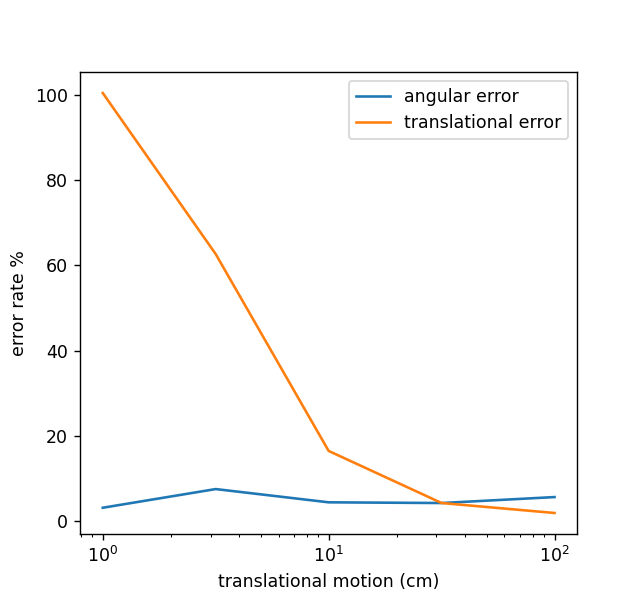

In [122]:
euler_err = np.array([[0.049696935, 0.020570586, 0.044756, 0.0260176, 0.0147433], 
                      [0.046620757, 0.101748, 0.0957834, 0.0514320, 0.079585],
                      [0.073563, 0.0446892, 0.03898206, 0.037205022, 0.02512616],
                      [0.047176, 0.025889, 0.0115295, 0.0872496, 0.039396811],
                      [0.0280946, 0.04086644, 0.11912304, 0.054875145, 0.0382422190]])
t_err = np.array([[0.864721, 0.259404678, 1.760131, 0.8736392, 1.265848], 
                  [0.3701675, 1.0649895, 0.5555488, 0.276301, 0.86642252],
                  [0.15310397, 0.0980089, 0.15720568, 0.26181809, 0.15266775],
                  [0.04077893, 0.008541906305, 0.065378099, 0.08126958, 0.015522921],
                  [0.00240634, 0.018018, 0.0529681, 0.0141170, 0.00673846]])
euler_err_avr = np.mean(euler_err, axis=1)
t_err_avr = np.mean(t_err, axis=1)
baselines = np.array([0.01, 0.03162277, 0.1, 0.3162277, 1.])
plt.plot(baselines*100, euler_err_avr * 100, label='angular error')
plt.plot(baselines*100, t_err_avr * 100, label='translational error')
plt.legend()
plt.ylabel("error rate %")
plt.xlabel("translational motion (cm)")
plt.xscale("log")
plt.show()
